*SIO221a Notes - Alford and Gille*

*Reading: Emery and Thomson 3.19*

Concepts covered: Monte Carlo methods, bootstrapping and jackknifing, Github practice

# Lecture 12

*Recap*

Last time we looked at spectral uncertainty and windowing.  We should now be getting fairly proficient at calculating spectra.  First we're going to go over Monte Carlo methods.  


**How many degrees of freedom do we have?**

We've got a full recipe, but how many degrees 
of freedom do we really have?

We'll try to sort this out today, along with venturing into Monte Carlo simulation.

Once you've created overlapping, windowed segments, then you'll need to
figure out how many independent segments you really have.  Clearly
at a minimum you should have the equivalent of the number of segments that
you would have if you did no overlapping.  If you have $N$ data points
divided into segments that are $M$ wide, then the minimum number of segments
is $N/M$.  But with windowing, the end points of each segment are used
less than the middle, making the overlapping segments more independent, so perhaps we have more degrees of freedom.  Since the segments overlap by 50\%,
we probably can't treat them as being independent. Bendat and Piersol usefully say that overlapping
by 50\% will recover about 90\% of the stability lost due to tapering.
How much
does the use of overlapping segments modulate the degrees of freedom?

 If you look this up in the 2nd
edition of Emery and Thomson, you find a nice table (their Table 5.6.4),
ostensably lifted from Priestley. Priestley's results are nicely
discussed by Koopmans (*The Spectral Analysis of Time Series*,
Academic Press, 1974).  Emery and Thomson describe the table as representing
the equivalent degrees of freedom for windowed "block averaged"
spectra.

A little further exploration of the literature shows that the values in Emery and Thomson's
table are incorrectly labeled and actually represent degrees of freedom
for spectra determined by filtering or averaging adjacent frequencies
from an initial spectral estimate.
If you filter in frequency, you can increase your degrees of freedom
just the way you increase degrees of freedom by using multiple segments.
And you can refine your filtering to reduce spectral ringing effects by
using a carefully constructed filter.  While people use the same types
of filters for time domain windowing/tapering and for frequency domain
filtering, the effect is not identical.  (If we wanted an identical effect,
we'd need to use the Fourier transform of the time domain window to filter
in the frequency domain.  You could do that, but it's not what we usually
envision when we talk about windowing or tapering, and it's not what Emery and
Thomson seem to describe.)  What this
means is that the tables of "equivalent degrees of freedom" for the
frequency domain don't actually work for windowed time domain data.

So at this point we have three options:

1. Abandon windowing and filter in the frequency domain, so that we can take advantage of the correct estimates of degrees of freedom.  This is a possibility, and we'll get to it, but it seems like we're unnecessarily giving up on the windowing approach that we've been exploring.

2. Use a brute strength approach---Monte Carlo simulation---to figure out how many degrees of freedom we have.

3. Find an analytic solution to decide how many degrees of freedom we have.




### Filtering in the frequency domain

When we talked about windowing, we noted that windowing in the time domain is
equivalent to convolution in the frequency
domain (and filtering in the time domain is equivalent to multiplication in the frequency
domain.)  This could lead you to an interesting conclusion.  What if you skipped all the
windowing and just did convolutions (i.e. filtering) in the frequency domain?  In the
limit in which you choose the same filter, these options should be the same.

This approach was originally developed by Daniell and is nicely discussed by von Storch and
Zwiers (see their section 12.3.11).  Daniell's original idea was to run a moving average
over the Fourier transform of the full record.  In this case the confidence intervals are
determined by:
$$
P\left(\chi_{\nu,1-\alpha/2}^2 < \nu \frac{\hat E(f)}{E(f)} <
\chi_{\nu,\alpha/2}^2\right)
$$
where $\nu$ in this case is 2 $\times$ the number of frequencies averaged together.

The advantages of this approach are that it provides an unbiased estimate of the true spectrum.
The width of our averaging forces us to tradeoff bias (minimized if we do less averaging)
vs variance (minimized with more averaging).  One virtue of averaging in the frequency
domain is that we  can apply different levels of averaging (with different error bars)
depending on the frequency.

**Monte Carlo simulation:  How to avoid the traps imposed by standard statistical 
assumptions (and how to fake your way as a statistician through computational inefficiency
rather than clever mathematics)**

Most of the time, we estimate spectral error bars using basic statistical assumptions---that 
data are normally distributed, that we have enough samples for the central limit theorem to
apply, that statistics are stationary.  These assumptions make our statistical models
tractable---we end up with equations we can manipulate, allowing us (or clever statisticians
100 years ago) to derive simple equations that give us rules for how systems should behave.
But what happens when those assumptions break down?  Or what happens when we have little doubts
about the validity of the statistical model.  We can always resort to a Monte Carlo process.
In Monte Carlo methods, we throw theory on its head and use an empirical approach to generate
many realizations of our data set, with noise appropriate to our problem. 

As an example, consider the problem of determining the standard error of the mean.
When we discussed it in class, we did a quick derivation to show that the standard 
error of the mean is $\sigma/\sqrt{N}$, where $\sigma$ is the standard deviation and
$N$ is the effective degrees of freedom.  But what if I didn't trust this estimate?
I could generate a large number of realizations of my data with noise typical of the real
data, compute means for each realization, and look at the statistics of those values. In your homework this week, you'll do this for spectra.

So let's put this to work.  Suppose I'm computing the mean of $N=500$ data points.  With one
sample, I can compute the mean $\mu$ and standard deviation $\sigma$, and standard error 
$\sigma/\sqrt{500}$.  But I might wonder
if $\mu$ is really representative.  So I can generate an ensemble of fake data, perhaps 100
data sets based on adding Gaussian white noise (or non-Gaussian white noise) to the real data.
Each of these data sets will have a mean $\mu_i$ and a standard deviation $\sigma_i$.  And I can
look at the standard deviation of all of the $\mu_i$ values.  I can also look at the pdf of
my $\mu_i$'s and other higher order statistics.
For example:


ans =

    0.0453    0.0446



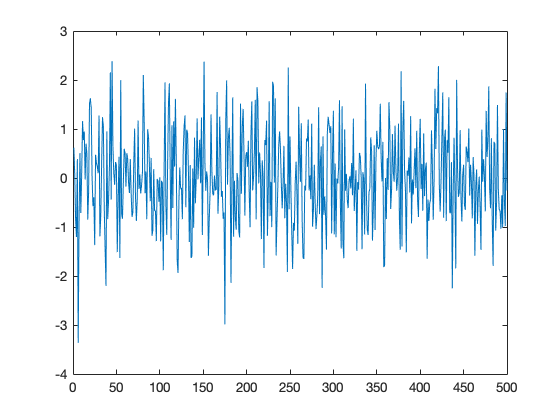

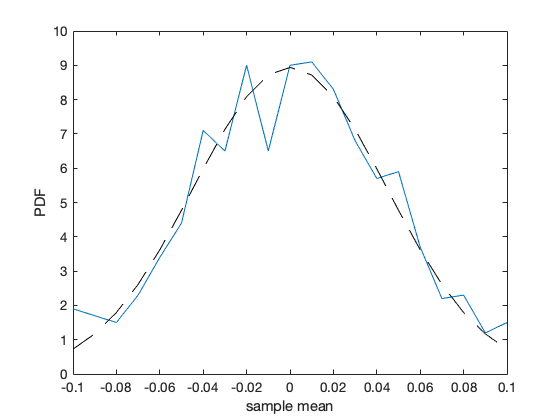

In [27]:
N=500; %number of samples in each ensemble
Nb=1000;%number of ensembles

A=randn(N,Nb); %Make 1000 realizations of fake data
mu=mean(A); %Compute the mean of each.
sigma_A=std(A); %And the standard deviation.  We expect this to be about one.

std_A=sigma_A/sqrt(500);

%plot(mu)
%So now we can compute the standard deviation of our computed means, 
%and compare that to the expected standard error of the mean.
[std(mu) mean(std_A)] % compare standard deviation of means
          %  vs standard error
figure(1)
plot(A(:,1))

figure(2)
dx=0.01;
x=-0.1:dx:.1;
[h,v]=hist(mu,x);
h=h./sum(h)./dx;
%And a Gaussian distribution
mu=0;
sig=mean(sigma_A)/sqrt(N);
%x=10:.1:30;
gauss=1./sig./sqrt(2*pi).*exp(-(x - mu).^2./2./sig.^2);

plot(x,h,x,gauss,'k--')
ylabel('PDF')
xlabel('sample mean')

Now we could expand on our example and ask, what if our noise were non-Gaussian, correlated, gappy
or had other problems, and we could adjust our Monte Carlo process appropriately.  And importantly, we can use this approach to test windowing strategies, by 
generating fake data with a white spectrum (or a known red or other spectral form), windowing,
segmenting, and evaluating the statistics of the solution---the standard deviation in log space---relative to the formal error bar.

This, by the way, is the basis of other general techniques for determining error bars that you'll see; namely, bootstrapping and jackknifing.




ans =

    0.0450    0.0135    0.0428



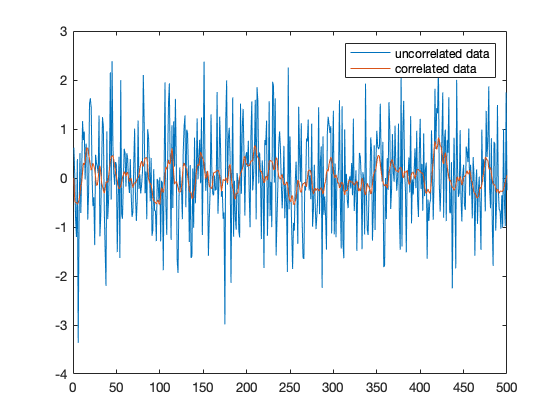

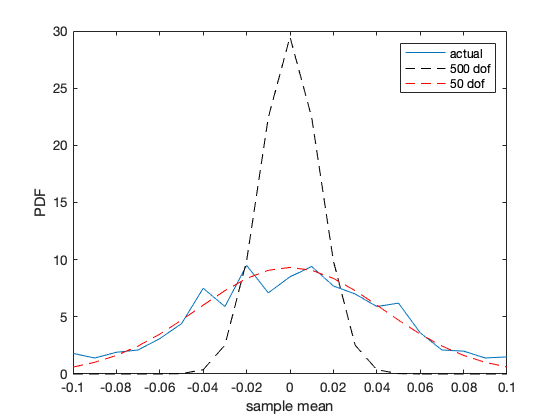

In [44]:
B=CenteredConv(A,1,10); %Now we have a dataset that is correlated.
mu=mean(B); %Compute the mean of each.
sigma_B=std(B); %And the standard deviation.  We expect this to be about one.

std_B=sigma_B/sqrt(500);

%plot(mu)
%So now we can compute the standard deviation of our computed means, 
%and compare that to the expected standard error of the mean.
[std(mu) mean(std_B)] % compare standard deviation of means
          %  vs standard error
figure(1)
plot(1:500,A(:,1),1:500,B(:,1))
legend('uncorrelated data','correlated data')
figure(2)
dx=0.01;
x=-0.1:dx:.1;
[h,v]=hist(mu,x);
h=h./sum(h)./dx;
%And a Gaussian distribution
mu=0;
sig=mean(sigma_B)/sqrt(N);
%x=10:.1:30;
gauss=1./sig./sqrt(2*pi).*exp(-(x - mu).^2./2./sig.^2);

N2=50; %Since we averaged ten data to make our correlated time series,
%we might expect a factor of ten reduction in degrees of freedom.
sig2=mean(sigma_B)/sqrt(N2);
%x=10:.1:30;
gauss2=1./sig2./sqrt(2*pi).*exp(-(x - mu).^2./2./sig2.^2);


plot(x,h,x,gauss,'k--',x,gauss2,'r--')
legend('actual','500 dof','50 dof')
ylabel('PDF')
xlabel('sample mean')

%plot(1:500,A(:,1),1:500,B(:,1))
%plot(1:M,std_A,1:M,std_B)

## Analytic approach to degrees of freedom for overlapping segments

Following Percival and Walden, we define  the following terms:
$$
N  =  \mbox{ total length of record} \\
N_B  =  \mbox{ number of blocks} \\
N_S  =  \mbox{ segment length or block size} \\
n  =  \mbox{ shift factor or number of points of overlap between segments} \\
h  =  \mbox{ window, normalized so that $h^2$ has a mean of 1}.
$$

Percival and Walden point out that the covariance between adjacent segments determines
the adjustment to the degrees of freedom, and this depends on $h$.

We can begin by writing out the expression for the variance of the spectral estimate:
$$
\mbox{var}\left\{\hat{S}^{(WOSA)}(f)\right\} =
$$

$$
\frac{1}{N_B} \sum_{j=0}^{N_B-1} \left(\mbox{var}\left\{\hat{S}_{jn+1}(f)\right\} +
\frac{2}{N_B} \sum_{j<k} \mbox{cov}\left\{\hat{S}_{jn+1}(f),\hat{S}_{kn+1}(f)\right\}\right),
$$
where $j$ and $k$ are indices for separate but overlapping segments.
The variance of the $j$th spectrum converges to the canonical
spectrum:
$$
\mbox{var}\left\{\hat{S}_{jn+1}(f)\right\} \approx S^2(f).
$$
The covariance depends on the overlap of the tapers or windows:
$$
\mbox{cov}\left\{\hat{S}_{jn+1}(f),\hat{S}_{kn+1}(f)\right\} \approx S^2(f)
\left|\sum_{t=1}^{N_S} h_t h_{t+|k-j|n}\right|^2,
$$
with  $h_t$ defined to be zero when $t$ is out of range (i.e. $t>N_S$).
This means that:
$$
\mbox{var}\left\{\hat{S}^{(WOSA)}(f)\right\} \approx 
S^2(f)\left(1+\frac{2}{N_B} \sum_{j<k}
\left|\sum_{t=1}^{N_S} h_t h_{t+|k-j|n}\right|^2\right)\\
 = 
S^2(f)\left(1+ 2\sum_{m=1}^{N_B-1} \left(1-\frac{m}{N_B}\right)
\left|\sum_{t=1}^{N_S} h_t h_{t+mn}\right|^2\right).
$$

Thus for a full record with arbitrary overlap:
$$
\nu \approx \frac{2N_B}{1 + 2\sum_{m=1}^{N_b-1} \left(1-\frac{m}{N_B}\right)
\left|\sum_{t=1}^{N_S} h_t h_{t+mn}\right|^2}.
$$
This formulation allows for arbitrary levels of overlap, so you could
imagine starting a new segment every data point and having to contend
with with lots of complicated covariances between adjacent segments.

For practical purposes, we typically work with 50\% overlap, so $n=N_S/2$.
In this case, Percival and Walden show that the equation for the
effective degrees of freedom simplifies to
$$
\nu \approx \frac{2N_B}{1 + 2\left(1-\frac{1}{N_B}\right)
\left|\sum_{t=1}^{N_S/2} h_t h_{t+N_S/2}\right|^2}.
$$

In the limit of large $N_B$ and many samples, it's relatively straightforward to find
an analytic solution:
$$
\nu \approx \frac{2N_B}{1 + 2 \left|\int_0^{L/2} h(t) h(t+L/2)\, dt\right|^2}.
$$
subject to the requirement that the window normalization is:
$$
\int_0^{L} h(t)^2 \, dt = 1.
$$
Thus for a boxcar filter, $h(t) = 1/\sqrt{L}$, and
$$
\int_0^{L/2} h(t)h(t+L/2)\, dt = \int_0^{L/2} \frac{1}{L}\, dt =
\left. \frac{t}{L}\right|_0^{L/2} = \frac{1}{2}.
$$
Thus
$$
\nu \approx \frac{2N_B}{1 + 2 \left| \frac{1}{2} \right|^2} = \frac{2N_B}{1+\frac{1}{2}}
= \frac{4N_B}{3}.
$$

Either analytically, or by plugging in normalized discrete window values $h_t$,
we can compute the adjustments to our effective degrees of freedom shown in
the table.  You'll see that these values provide a fairly effective
match to the values that you obtained from Monte Carlo simulation.

| Window Type | Equiv. DOF |
| --- | ----------- |
| Boxcar | 4/3 |
| Triangle |  16/9 |
| Hanning |  36/19 $\approx$ 1.90 | 
| Hamming |  $\sim$1.80 | 

Table: Effective number of degrees of freedom relative to the total number
of segments, using 50\% overlap.  (With no overlap, the equivalent degrees of
freedom would be double the number of segments.)

*A note on pesky factors of two:*
Say I were using 20 chunks of unoverlapped data and used a box car window.  We know then that this gives $\nu$=40 (positive and negative coeffs for each chunk).  If we use half overlapping box car chunks, this table says that we get $\nu=4/3*39=52$ (39 is the number of total chunks we have if we use a half overlap).  You can get yourself out of trouble also by recalling that half-overlapping boxcar chunks can't give *less* information than non-overlapping chunks, so you'd better not wind up with $\nu$ less than 40.

If we were to use a Hamming window, this says we would get more (because the windowed chunks are less correlated owing to their low amplitude near the edges): $\nu=1.8*39=2(0.9)*39\approx 70$.  You'll verify this in the homework. 


Finally, Percival and Walden note that we can also consider overlaps other
than 50\%, by adjusting $m$ in their original equation:
$$
\nu \approx \frac{2N_B}{1 + 2\sum_{m=1}^{N_b-1} \left(1-\frac{m}{N_B}\right)
\left|\sum_{t=1}^{N_S-mn} h_t h_{t+mn}\right|^2}.
$$
Their Figure 293 shows degrees of freedom as a function of overlap for
the Hanning window.  We can code this in Matlab to consider other windows
as well:

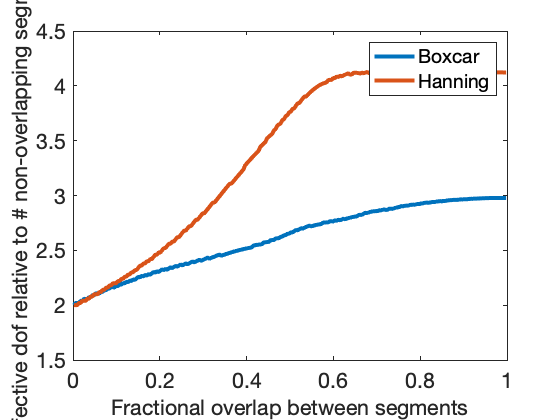

In [33]:
Ns=512;
n=256;
N=Ns*100;
Nb_theory=N/Ns;

h=ones(Ns,1)/sqrt(Ns);
for n=1:Ns-1
Nb=round((N-Ns)/n+1);
sumh=[];
for m=1:Nb-1
 if(Ns-m*n>=1)
  sumh(m)=(1-m/Nb)*abs(sum(h(1:Ns-m*n).*h(1+m*n:Ns)))^2;
 end
end
denom=1+2*sum(sumh);
nu_boxcar(n)=2*Nb/denom;
end

h=sqrt(2/3/Ns)*(1-cos(2*pi*(1:Ns)/Ns));

for n=1:511
Nb=floor((N-Ns)/n+1);
sumh=[];
for m=1:Nb-1
 if(Ns-m*n>=1)
  sumh(m)=(1-m/Nb)*abs(sum(h(1:Ns-m*n).*h(1+m*n:Ns)))^2;
 end
end
denom=1+2*sum(sumh);
nu_hanning(n)=2*Nb/denom;
end


hold off
plot(1-(1:2:Ns-1)/Ns,nu_boxcar(1:2:end)/Nb_theory,'LineWidth',3);
hold on
plot(1-(1:2:Ns-1)/Ns,nu_hanning(1:2:end)/Nb_theory,'LineWidth',3);
set(gca,'FontSize',16)
xlabel('Fractional overlap between segments','FontSize',16)
ylabel('Effective dof relative to # non-overlapping segments',...
   'FontSize',16)
legend('Boxcar','Hanning')



## Bootstrapping and Jackknifing

Boot strapping and jackknifing are Monte Carlo methods wherein we take a limited dataset and repeatedly sample it randomly to generate a larger dataset (or equivalently, multiple realizations of the same dataset.  We assume the sample we have is representative, but do not make any assumptions such as Gaussianity. Boot strapping resamples our data; jackknifing generates multiple datasets by deleting different values.

The beauty of boot strapping and jackknifing is we use the actual data, which has the statistics it has, but resample it as many times as we need.  We can then use those "boosted" numbers to look at statistics of whatever we want - the standard deviation, the PDF, or even the statistics of computed parameters such as model coefficients (e.g. to determine error bars on a slope fit for example).

The first example we will use is some turbulence data collected from our cruise in summer 2022.  Turbulence data are notoriously "intermittent" - or more precisely, they follow a lognormal distribution.  We can use boot strapping techniques to estimate error bars.



![Epsi-fish Photo](./images/IMG_4790.jpeg 
"Epsi-fish system")

![Epsi-fish Example](./images/jul21-MAVS2-spring.jpg 
"Example epsi-fish turbulence data")

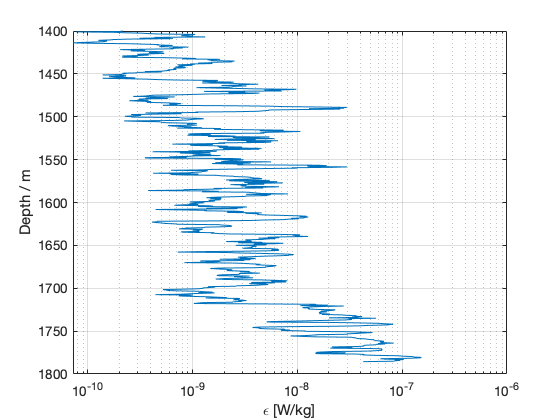

In [46]:
addpath('/Users/malford/GoogleDrive/Work/Projects/Teaching/sio221a/SIO221a_Github_code/')
load eps_BLT_example
%%
figure(1)
semilogx(eps.epsilon,eps.z);axis ij;
grid
ylabel('Depth / m')
xlabel('\epsilon [W/kg]')
shg

In [48]:
%Let's look at deep and shallow statistics
ideep=find(eps.z>1725);
ishallow=find(eps.z<1725);
nanstd(eps.epsilon(ishallow))

%So if I were to average over 50 m, I'd expect N=100 or 
%a 10-fold reduction in stadard error.
std_err_50m=ans / 10



ans =

   3.8925e-09


std_err_50m =

   3.8925e-10



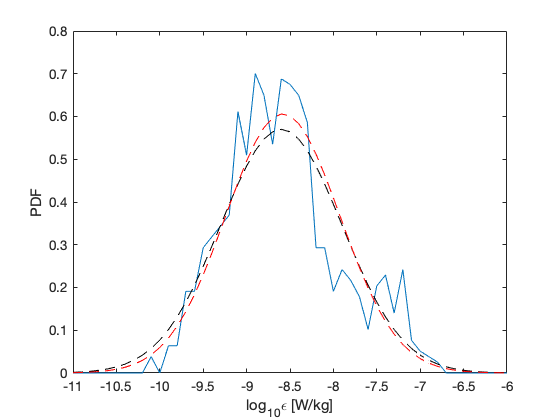

In [51]:
%Look at the distribution.
v=-11:.1:-6;
%plot(v,h) 
[h,v]=hist(log10(eps.epsilon),v);
[hshallow,v]=hist(log10(eps.epsilon(ishallow)),v);
[hdeep,v]=hist(log10(eps.epsilon(ideep)),v);
mu=-8.6;
sig=0.7;
x=v;
gauss=1./sig./sqrt(2*pi).*exp(-(x - mu).^2./2./sig.^2);

mu2=nanmean(stats(:,1));
sig2=nanmean(stats(:,2));

gauss2=1./sig2./sqrt(2*pi).*exp(-(x - mu2).^2./2./sig2.^2);


figure(2)
plot(v,h./sum(h)./0.1,x,gauss,'k--',x,gauss2,'r--')
xlabel('log_{10}\epsilon [W/kg]')
ylabel('PDF')
%%

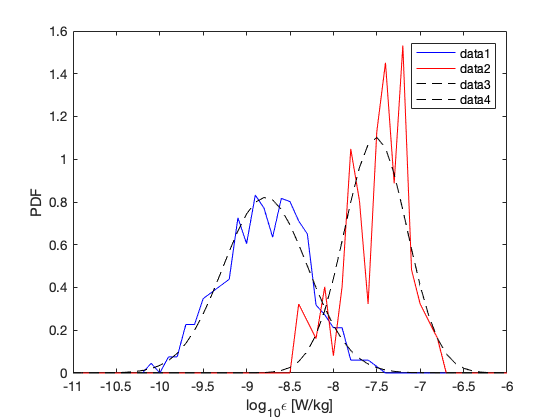

In [50]:
stats = bootstrp(100, @(x) [mean(x) std(x)], log10(eps.epsilon));
stats_shallow = bootstrp(100, @(x) [mean(x) std(x)], log10(eps.epsilon(ideep)));
stats_deep = bootstrp(100, @(x) [mean(x) std(x)], log10(eps.epsilon(ishallow)));


mud=nanmean(stats_deep(:,1));
sigd=nanmean(stats_deep(:,2));
gaussd=1./sigd./sqrt(2*pi).*exp(-(x - mud).^2./2./sigd.^2);

mus=nanmean(stats_shallow(:,1));
sigs=nanmean(stats_shallow(:,2));
gausss=1./sigs./sqrt(2*pi).*exp(-(x - mus).^2./2./sigs.^2);



figure(3)
plot(v,hshallow./sum(hshallow)./0.1,'b-',v,hdeep./sum(hdeep)./0.1,'r-',x,gausss,'k--',x,gaussd,'k--')
legend()
xlabel('log_{10}\epsilon [W/kg]')
ylabel('PDF')

Another example is from the SIO pier temperature record, where we can use boot strapping to estimate error bars even though our record is short and the data are not that Gaussian. In this case, the answer we obtain is close to what we would have assumed from Gaussian statistics.

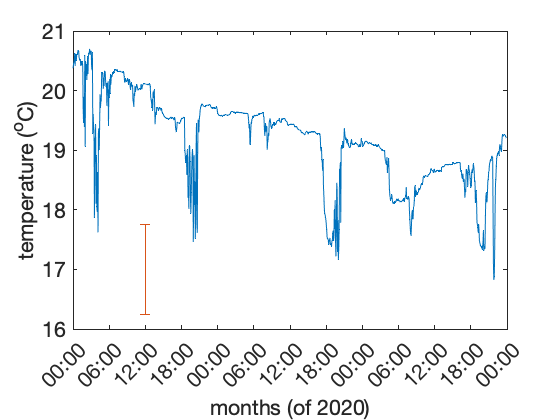

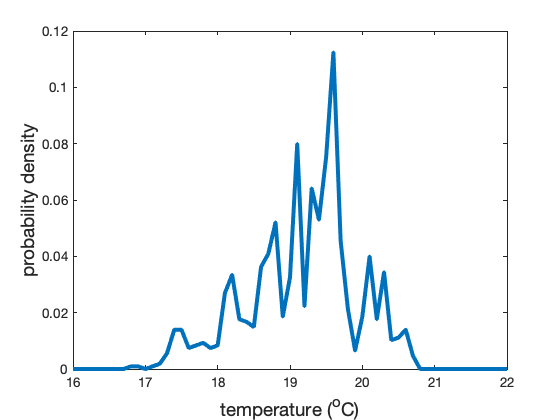

In [18]:
%Pier temperature example

%First we can add it to our path:
addpath('/Users/malford/GoogleDrive/Work/Projects/Teaching/sio221a/SIO221a_Github_code/') %You might need to modify this depending on your path and current directory.

pier=Get2020PierData(datenum(2020,6,4,0,0,0),datenum(2020,6,7,0,0,0));
[number_per_bin,bins]=hist(pier.temperature,16:.1:22);

err=nanstd(pier.temperature);
%Now let's compute boot strapped errors. 
%[lbx,mx,ubx] = bootstd(pier.temperature,100,95);
stats = bootstrp(100, @(x) [mean(x) std(x)], pier.temperature);
figure(1)
%plot(pier.dnum,pier.temperature,'LineWidth',1)
plot(pier.dnum,pier.temperature)
hold on
%errorbar(datenum(2020,6,4,6,0,0),17,err)
errorbar(datenum(2020,6,4,12,0,0),17,nanmean(stats(:,2)))

hold off
datetick('x')
set(gca,'FontSize',16)
xlabel('months (of 2020)','FontSize',16)
ylabel('temperature (^oC)', 'FontSize',16)

figure(2)
plot(bins,number_per_bin/sum(number_per_bin),'LineWidth',3)
xlabel('temperature (^oC)','FontSize',14)
ylabel('probability density','FontSize',14)

*Github demo:*  First, we'll load in the spectrum we computed before using the function you wrote and pushed to the Github repo.  

The class coding and Github exercise is for a MATLAB and a Python group to write a little Jupyter notebook to verify that two different spectral functions give equivalent answers.

Please do the following in groups of two or three (each group should use the same language, either MATLAB or Python):

1. Sync/pull your Github
2. Each person writes a well-commented function to read data and time and a specified chunk size or number of chunks, and compute the spectrum. Units should be correct and Parseval should hold.
3. Push your function to Github in the folder class10_coding_github_exercise.
4. In a Jupyter notebook, 
    1. Load in the data file class10_record.mat in class10_coding_github_exercise (MATLAB users: please help Python users convert the file if needed).
    2. Call each group member's function
    3. Plot the spectra on the same axes; label x and y axes
    4. Iterate and re-push as needed until plots agree.

